In [17]:
# immport section

import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [18]:
NUM_TRADING_DAYS = 252 # for calculating annual retuns, we consider a financial ear have 252 working days. 
NUM_PORTFOLIOS = 10000 # we'll simulate the portfolio 10000 times, to get the best portfolio with max sharpe ratio out of sampled 10000. 
stocks = ["AAPL", "GS", "JPM", "MSFT", "MCD", "WMT"] # list of stocks to be considered.

In [35]:
def download_data():
    stocks_data = yf.download(stocks, start = '2016-1-1', end = '2021-12-31')['Adj Close'] # downloading the adj clos price data of stocks for the period of time. 
    stocks_data = stocks_data.dropna(axis=1) # removing any stock if it has nan values. 
    stocks_data.to_csv("stocks_data-2.csv")
download_data()

[*********************100%***********************]  6 of 6 completed


In [36]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()
# usiing this code to plot the line chart of stocks performance. 

In [37]:
stcoskk_data = pd.read_csv("stocks_data-2.csv")
stcoskk_data

,Date,AAPL,GS,JPM,MCD,MSFT,WMT
0,2015-12-31,24.090899,158.374420,54.246765,99.263977,49.740349,52.994839
1,2016-01-04,24.111502,155.659119,52.617458,98.793427,49.130692,53.133171
2,2016-01-05,23.507288,152.978989,52.708435,100.154610,49.354828,54.395363
3,2016-01-06,23.047253,149.244385,51.947540,99.482437,48.458282,54.940010
4,2016-01-07,22.074556,144.657364,49.846809,97.180206,46.772778,56.219490
...,...,...,...,...,...,...,...
1506,2021-12-23,175.262817,375.142609,152.448257,260.124146,331.583008,137.331238
1507,2021-12-27,179.289444,378.065521,153.320740,262.363953,339.270996,138.581573
1508,2021-12-28,178.255432,377.646576,153.786026,262.011841,338.082123,140.570312
1509,2021-12-29,178.344925,376.272858,153.708481,262.608459,338.775665,140.501419


In [38]:
stocks_df = pd.read_csv("stocks_data-2.csv", index_col=0)
assets = stocks_df.columns.values
assets
# getting list of selected assets, i.e. the one who are not dropped from stocks list.

array(['AAPL', 'GS', 'JPM', 'MCD', 'MSFT', 'WMT'], dtype=object)

In [39]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1)) # calculaitng log returns of a next day with today. 
    return log_return[1:]

In [40]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [41]:
def show_mean_variance(returns, weights):
    # calculates returns, variance and sharpe ratio of the optimied portfolios. 
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [42]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    # this code draws the efficient frontier curve. 
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [43]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [44]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        # simulates the portfolios for 10000 number of times to find the portfolio whose sharpe ratio is maximum. 
        w = np.random.random(len(assets))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [45]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [46]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [47]:
def optimize_portfolio(weights, returns):
    # this finds out weights for optimized portfolio. 
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(assets)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)

In [48]:
def print_optimal_portfolio(optimum, returns):
    
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))
    

In [49]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    # plots the efficient frontier curve with the optimum portfolio and mark it as star. 
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

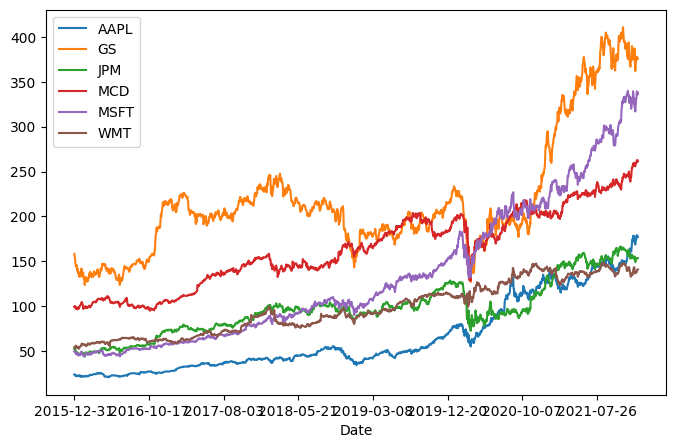

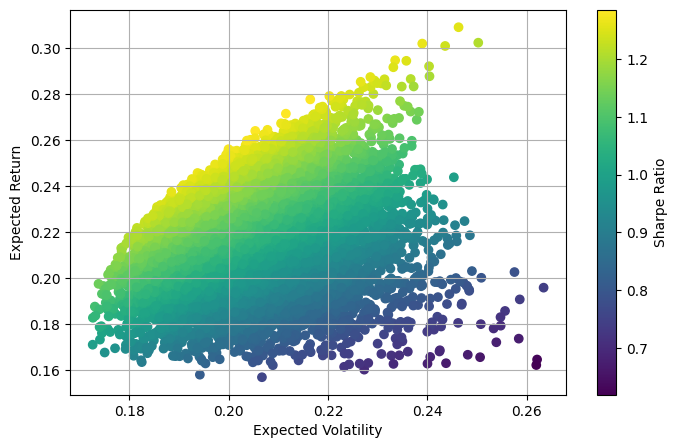

Optimal Portfolio:  [0.292 0.    0.    0.069 0.4   0.239]
Expected return, volatility and sharpe ratio:  [0.27495407 0.21228679 1.29520105]


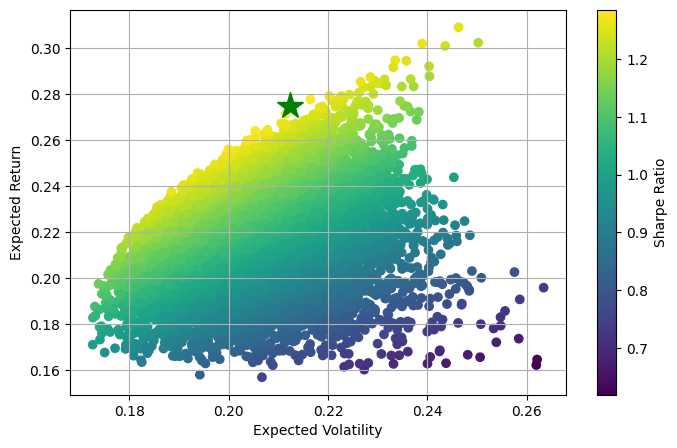

In [50]:
if __name__ == '__main__':
    
    ## first get the data 
    dataset = pd.read_csv("stocks_data-2.csv", index_col= 0)
    show_data(dataset)
    
    ## then calculates the log returns
    log_daily_returns = calculate_return(dataset)
    
    ## generates portfolios by simulations
    pweights, means, risks = generate_portfolios(log_daily_returns)
    ## shows all the portfolios 
    show_portfolios(means, risks)
    
    ## finds the optimum portfolio and associated weights 
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [51]:
def get_weights_sharpe(optimum, returns):
    weights = (optimum['x'].round(3))*100
    sharpe_ratio = statistics(optimum['x'].round(3), returns)
    # this code reads the weights of the optimized portfolio. 
    return weights, sharpe_ratio

In [52]:
weights, sharpe = get_weights_sharpe(optimum, log_daily_returns)

In [53]:
weights_alloc = dict(zip(assets, weights))
weights_alloc

{'AAPL': 29.2, 'GS': 0.0, 'JPM': 0.0, 'MCD': 6.9, 'MSFT': 40.0, 'WMT': 23.9}

In [54]:
# get the returns, risk, sharpe ratio of a portfolio. 
portfolio_returns, portfolio_risk, portfolio_sharpe = sharpe[0], sharpe[1], sharpe[2]
sharpe_dict = {
    "portfolio (annual) returns are " : portfolio_returns*100,
    "portfolio  risk is " : portfolio_risk*100,
    "portfolio sharpe ratio is " : portfolio_sharpe,
    
}
sharpe_dict

{'portfolio (annual) returns are ': 27.49540737446967,
 'portfolio  risk is ': 21.228679003477474,
 'portfolio sharpe ratio is ': 1.2952010518396195}

In [55]:
weights_dict = {k: v for k, v in weights_alloc.items() if v}
my_weights = list(weights_dict.values())
my_assets = list(weights_dict.keys())
my_weights

[29.2, 6.9, 40.0, 23.9]

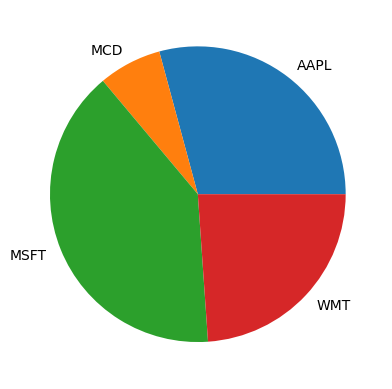

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# draws a pie chart of weights distribution. 

y = np.array(my_weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [57]:
# draws a table to show to a user of weights distribution. 
weights_table = pd.DataFrame([weights_dict]).T 
weights_table

,0
AAPL,29.2
MCD,6.9
MSFT,40.0
WMT,23.9
